In [5]:
import pandas as pd
import json
import os

# Set your data folder path

# Print the current working directory
print("Current Working Directory:\n", os.getcwd())
# set working directory to the data folder

# Show the contents of current directory
print("Contents of Current Directory:\n", os.listdir(os.getcwd()))
# print working directory
data_folder = os.path.join(os.getcwd())
print("Data Folder Path:\n", data_folder)

# List of your Reddit JSON files
reddit_json_files = [
    "data/old_data/r_air_pollution.json",
    "data/old_data/output.json"
    # add more if needed
]

# List of your News JSON files
news_json_files = [
    "data/old_data/news_api_1airpollution.json",
]

# -------------------
# HELPER FUNCTIONS
# -------------------

# Load Reddit comments
def load_reddit_comments(file_path):
    comments = []
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        if isinstance(data, list):
            for post in data:
                if 'comments' in post:
                    for comment in post['comments']:
                        if comment and comment.strip() and comment != '[deleted]':
                            comments.append(comment.strip())
    reddit_df = pd.DataFrame({'text': comments, 'source': 'reddit'})
    return reddit_df

# Load News articles
def load_news_articles(file_path):
    articles = []
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        if isinstance(data, dict) and 'articles' in data:
            for article in data['articles']:
                if 'content' in article and article['content']:
                    articles.append(article['content'].strip())
    news_df = pd.DataFrame({'text': articles, 'source': 'news'})
    return news_df

# -------------------
# LOAD ALL FILES
# -------------------

reddit_data = []
news_data = []

for file in reddit_json_files:
    reddit_data.append(load_reddit_comments(file))

for file in news_json_files:
    news_data.append(load_news_articles(file))

# Combine into two DataFrames
reddit_df = pd.concat(reddit_data, ignore_index=True)
news_df = pd.concat(news_data, ignore_index=True)

# Final combined corpus
full_corpus = pd.concat([reddit_df, news_df], ignore_index=True)

print("Full Corpus Shape:", full_corpus.shape)
print(full_corpus.head())


Current Working Directory:
 /Users/davidlapaglia/Documents/School/INFO Coding/INFO_5652/text_mining-4
Contents of Current Directory:
 ['ANN.ipynb', '.vscode', 'data']
Data Folder Path:
 /Users/davidlapaglia/Documents/School/INFO Coding/INFO_5652/text_mining-4
Full Corpus Shape: (8448, 2)
                                                text  source
0         What is the reason for the drastic change?  reddit
1  Two and a half packs for anyone unfamiliar wit...  reddit
2  What happened on 27 sept 2024 to make it so cl...  reddit
3                  This makes smoking looks less bad  reddit
4  On the other hand that’s a lot of value, 50 ci...  reddit


In [6]:
import re

# Expanded positive/negative keyword sets
positive_keywords = [
    "climate", "global warming", "renewable", "carbon neutral", "sustainability",
    "greenhouse gases", "net zero", "climate action", "solar", "clean energy",
    "environment", "emissions", "carbon footprint", "climate mitigation",
    "climate adaptation", "biodiversity", "ecosystem", "energy transition",
    "carbon capture", "climate resilience", "green economy"
]

negative_keywords = [
    "climate hoax", "fake science", "global cooling", "scam", "not real",
    "climate agenda", "fear mongering", "exaggerated", "political tool",
    "no evidence", "climate fraud", "hysteria", "propaganda", "alarmism",
    "climate scam", "fake climate", "climate denial", "hoax", "misinformation",
    "fake news", "overblown", "sensationalism"
]

# Precompile regex patterns
positive_pattern = re.compile(r'\b(' + '|'.join(re.escape(word) for word in positive_keywords) + r')\b', flags=re.IGNORECASE)
negative_pattern = re.compile(r'\b(' + '|'.join(re.escape(word) for word in negative_keywords) + r')\b', flags=re.IGNORECASE)

# Super robust auto-label function
def very_robust_auto_label(text):
    text_lower = str(text).lower()
    
    pos_matches = positive_pattern.findall(text_lower)
    neg_matches = negative_pattern.findall(text_lower)
    
    pos_count = len(pos_matches)
    neg_count = len(neg_matches)
    
    if pos_count > neg_count:
        return 1  # Positive leaning
    elif neg_count > pos_count:
        return 0  # Negative leaning
    else:
        return -1  # Unclear or neutral

# Apply the improved labeling
full_corpus['label'] = full_corpus['text'].apply(very_robust_auto_label)

# Check the new distribution
print(full_corpus['label'].value_counts())


label
-1    7624
 1     763
 0      61
Name: count, dtype: int64


In [7]:
full_corpus_labeled = full_corpus[full_corpus['label'] != -1]

print("Final labeled dataset shape:", full_corpus_labeled.shape)
print(full_corpus_labeled.head())

Final labeled dataset shape: (824, 3)
                                                 text  source  label
16  It is fascinating to me that there are people ...  reddit      1
32  Reading through the comments, why is everyone ...  reddit      1
37  Hopefully this will be a wake up call to India...  reddit      1
67  Why does the US constantly get criticized and ...  reddit      1
69  Remember this shit next time the EPA wants to ...  reddit      1


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate the vectorizer
vectorizer = CountVectorizer(
    stop_words='english',
    max_features=10000,  # you can tweak this
    lowercase=True
)

# Balance the dataset
from sklearn.utils import resample
# Separate majority and minority classes
majority = full_corpus_labeled[full_corpus_labeled['label'] == 1]
minority = full_corpus_labeled[full_corpus_labeled['label'] == 0]
# Upsample minority class
minority_upsampled = resample(minority,
                               replace=True,     # sample with replacement
                               n_samples=len(majority),    # to match majority class
                               random_state=42) # reproducible results
# Combine majority class with upsampled minority class
upsampled = pd.concat([majority, minority_upsampled])
# Check new class counts
print(upsampled['label'].value_counts())
# Split the data

# Use the balanced dataset for vectorization
X = vectorizer.fit_transform(upsampled['text'])
y = upsampled['label'].values


print("X shape:", X.shape)
print("y shape:", y.shape)

label
1    763
0    763
Name: count, dtype: int64
X shape: (1526, 6392)
y shape: (1526,)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Train/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (1220, 6392) (306, 6392)


In [10]:
import tensorflow as tf
from tensorflow import keras

# Build ANN
model = keras.models.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

# Compile ANN
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train ANN
history = model.fit(
    X_train.toarray(), y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test.toarray(), y_test)
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       818,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 826,625 (3.15 MB)

 Trainable params: 826,625 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6128 - loss: 0.6437 - val_accuracy: 1.0000 - val_loss: 0.3749
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9896 - loss: 0.2916 - val_accuracy: 0.9967 - val_loss: 0.0542
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0373 - val_accuracy: 0.9967 - val_loss: 0.0167
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.9967 - val_loss: 0.0118
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.9967 - val_loss: 0.0119


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


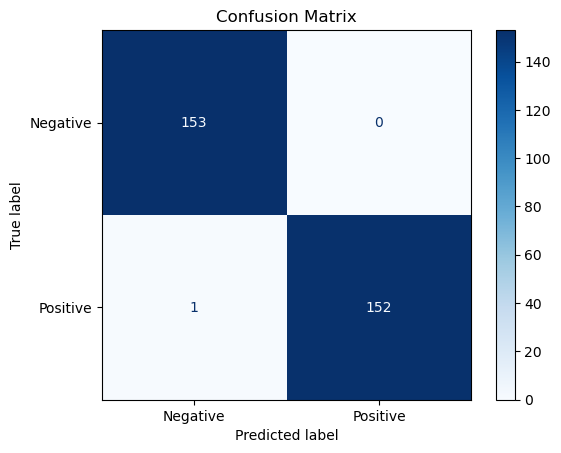

Classification Report:

              precision    recall  f1-score   support

    Negative       0.99      1.00      1.00       153
    Positive       1.00      0.99      1.00       153

    accuracy                           1.00       306
   macro avg       1.00      1.00      1.00       306
weighted avg       1.00      1.00      1.00       306



In [13]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# First, make predictions on the test set
y_pred_prob = model.predict(X_test.toarray())
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()  # Threshold at 0.5

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# 2. Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 3. Classification Report (Precision, Recall, F1, Accuracy)
report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
print("Classification Report:\n")
print(report)


In [14]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights automatically
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Then in model.fit():
history = model.fit(
    X_train.toarray(), y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test.toarray(), y_test),
    class_weight=class_weights_dict
)


Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9967 - val_loss: 0.0128
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9967 - val_loss: 0.0143
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9967 - val_loss: 0.0150
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9967 - val_loss: 0.0150
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 8.8143e-04 - val_accuracy: 0.9967 - val_loss: 0.0143


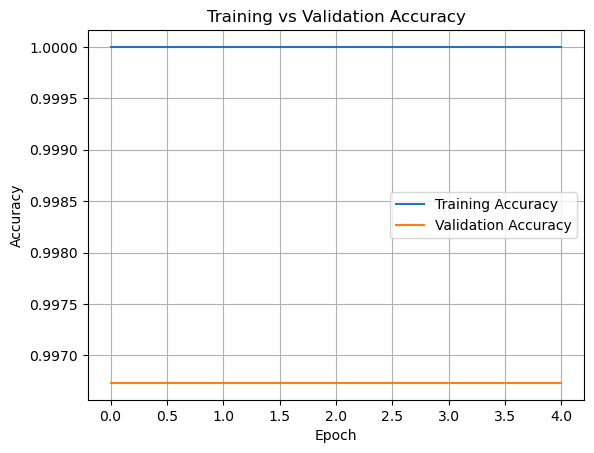

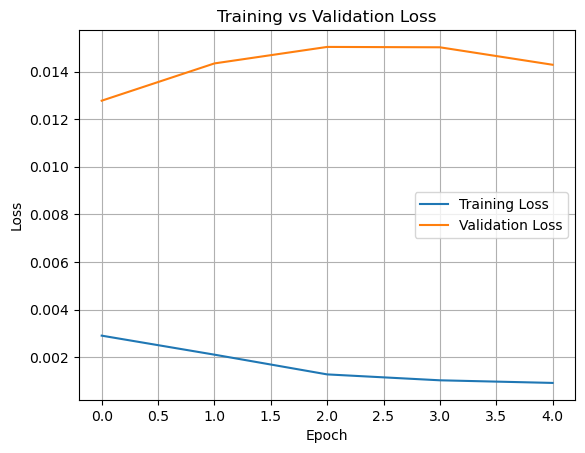

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


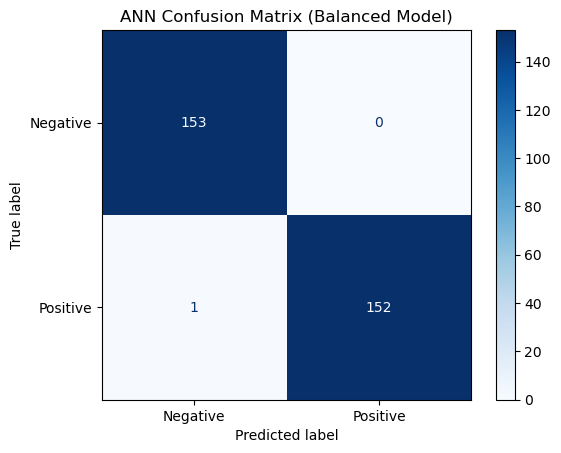

ANNClassification Report:

              precision    recall  f1-score   support

    Negative       0.99      1.00      1.00       153
    Positive       1.00      0.99      1.00       153

    accuracy                           1.00       306
   macro avg       1.00      1.00      1.00       306
weighted avg       1.00      1.00      1.00       306



In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# -------------------
# 1. Plot Accuracy Over Epochs
# -------------------
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -------------------
# 2. Plot Loss Over Epochs
# -------------------
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# -------------------
# 3. Confusion Matrix
# -------------------

# Make predictions on the test set
y_pred_prob = model.predict(X_test.toarray())
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title('ANN Confusion Matrix (Balanced Model)')
plt.show()

# -------------------
# 4. Classification Report
# -------------------

report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
print("ANNClassification Report:\n")
print(report)


Top words in positive class:
emissions: 293
climate: 284
pollution: 251
air: 232
people: 210
nuclear: 203
environment: 202
carbon: 197
change: 192
just: 185
like: 178
energy: 165
power: 160
https: 144
china: 140
global: 125
solar: 117
don: 115
warming: 112
co2: 107

Top words in negative class:
propaganda: 418
pollution: 325
air: 320
like: 303
people: 296
nuclear: 247
just: 174
grid: 144
vehicle: 144
don: 138
use: 129
misinformation: 124
power: 124
scam: 118
china: 112
isn: 110
energy: 107
co2: 104
chinese: 102
carbon: 101


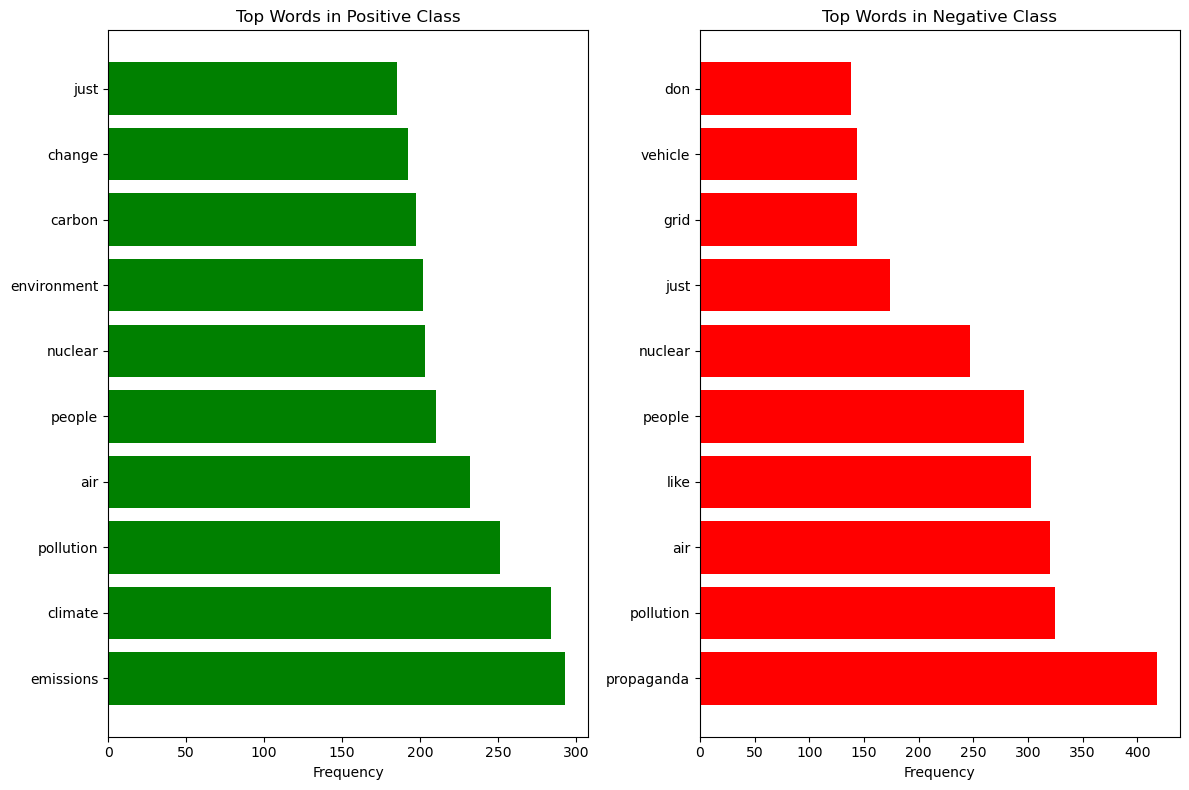

In [16]:
# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# For positive class sentiment indicators
# Get samples classified as positive
positive_samples = upsampled[upsampled['label'] == 1]['text']
positive_matrix = vectorizer.transform(positive_samples)
positive_sums = positive_matrix.sum(axis=0)
positive_frequencies = [(feature_names[i], positive_sums[0, i]) for i in range(len(feature_names))]
top_positive = sorted(positive_frequencies, key=lambda x: x[1], reverse=True)[:20]

# For negative class sentiment indicators
negative_samples = upsampled[upsampled['label'] == 0]['text']
negative_matrix = vectorizer.transform(negative_samples)
negative_sums = negative_matrix.sum(axis=0)
negative_frequencies = [(feature_names[i], negative_sums[0, i]) for i in range(len(feature_names))]
top_negative = sorted(negative_frequencies, key=lambda x: x[1], reverse=True)[:20]

# Print top words for each class
print("Top words in positive class:")
for word, count in top_positive:
    print(f"{word}: {count}")
    
print("\nTop words in negative class:")
for word, count in top_negative:
    print(f"{word}: {count}")

# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Top positive words
plt.subplot(1, 2, 1)
words, counts = zip(*top_positive[:10])
plt.barh(words, counts, color='green')
plt.title('Top Words in Positive Class')
plt.xlabel('Frequency')

# Top negative words
plt.subplot(1, 2, 2)
words, counts = zip(*top_negative[:10])
plt.barh(words, counts, color='red')
plt.title('Top Words in Negative Class')
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
True label: Positive
Explanation:
Americans: 0.0011
Change: 0.0010
owned: 0.0009
change: 0.0009
current: 0.0009
Reddit: -0.0002
just: 0.0001
if: 0.0001
companies: 0.0001
literally: -0.0000


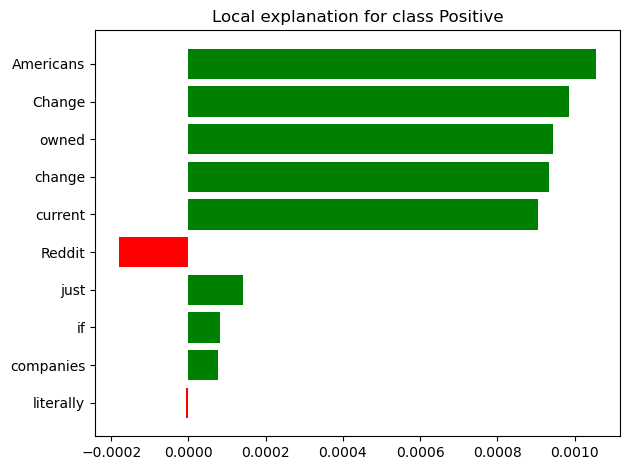

In [27]:
# !pip install lime
# The predict_proba function for LIME needs to return a 2D array with probabilities for BOTH classes
def predict_proba(texts):
    # Convert texts to the same format used in training
    text_features = vectorizer.transform(texts)
    
    # Get the raw predictions (these are likely just single values between 0 and 1)
    raw_preds = model.predict(text_features)
    
    # LIME expects 2D array with probabilities for each class
    # For binary classification, we need [probability_of_class_0, probability_of_class_1]
    # If your model outputs single values, we need to convert to proper format
    if len(raw_preds.shape) == 1 or raw_preds.shape[1] == 1:
        # For sigmoid outputs (0 to 1 representing probability of class 1)
        probs_class_1 = raw_preds.flatten()
        probs_class_0 = 1 - probs_class_1
        return np.column_stack([probs_class_0, probs_class_1])
    else:
        # If model already outputs probabilities for both classes
        return raw_preds

import lime
from lime.lime_text import LimeTextExplainer
import numpy as np

# Create an explainer
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])

# Choose a sample to explain
idx = 10  # Choose any sample index
text_to_explain = upsampled['text'].iloc[idx]
true_label = upsampled['label'].iloc[idx]

# Generate an explanation
exp = explainer.explain_instance(text_to_explain, predict_proba, num_features=10)

# Display the explanation
print(f"True label: {'Positive' if true_label == 1 else 'Negative'}")
print("Explanation:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

# Visualize the explanation
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

In [25]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def get_keyword_context(kw, text_list, window=5):
    """Show keywords in their context"""
    result_contexts = []
    pattern = re.compile(r'\b' + re.escape(kw) + r'\b', re.IGNORECASE)
    
    for text in text_list:
        if pattern.search(str(text)):
            words = str(text).split()
            for i, word in enumerate(words):
                if pattern.search(word):
                    start = max(0, i - window)
                    end = min(len(words), i + window + 1)
                    context = ' '.join(words[start:end])
                    result_contexts.append(f"...{context}...")
                    break
    
    return result_contexts

# Define keywords to analyze
keywords_to_check = ["climate", "global warming", "hoax", "fake", "scam", "renewable", "sustainability", "pollution"]

# Analysis for each keyword
for keyword in keywords_to_check:
    print(f"\n{'='*50}\nAnalyzing keyword: '{keyword}'\n{'='*50}")
    
    # For positive class
    positive_texts = upsampled[upsampled['label'] == 1]['text'].tolist()
    positive_contexts = get_keyword_context(keyword, positive_texts, window=5)
    positive_count = sum(1 for text in positive_texts if re.search(r'\b' + re.escape(keyword) + r'\b', str(text).lower()))
    
    print(f"'{keyword}' appears in {positive_count} out of {len(positive_texts)} positive texts ({positive_count/len(positive_texts)*100:.1f}%)")
    
    if positive_contexts:
        print(f"\n'{keyword}' in positive contexts:")
        for i, context in enumerate(positive_contexts[:5]):  # Show first 5 examples
            print(f"{i+1}. {context}")
    else:
        print(f"No examples of '{keyword}' found in positive contexts.")
    
    # For negative class
    negative_texts = upsampled[upsampled['label'] == 0]['text'].tolist()
    negative_contexts = get_keyword_context(keyword, negative_texts, window=5)
    negative_count = sum(1 for text in negative_texts if re.search(r'\b' + re.escape(keyword) + r'\b', str(text).lower()))
    
    print(f"\n'{keyword}' appears in {negative_count} out of {len(negative_texts)} negative texts ({negative_count/len(negative_texts)*100:.1f}%)")
    
    if negative_contexts:
        print(f"\n'{keyword}' in negative contexts:")
        for i, context in enumerate(negative_contexts[:5]):  # Show first 5 examples
            print(f"{i+1}. {context}")
    else:
        print(f"No examples of '{keyword}' found in negative contexts.")

# Visualization of keyword frequencies in each class
plt.figure(figsize=(12, 8))

# Calculate


Analyzing keyword: 'climate'
'climate' appears in 203 out of 763 positive texts (26.6%)

'climate' in positive contexts:
1. ...mankind could never affect the climate or environment....
2. ...call to India to take climate change seriously...
3. ...attacked for its role in climate change, and at the same...
4. ...If you want to stop climate change, maybe let's look at...
5. ...Where's Bill Gates spewing his climate bullshit to the Indian government?...

'climate' appears in 0 out of 763 negative texts (0.0%)
No examples of 'climate' found in negative contexts.

Analyzing keyword: 'global warming'
'global warming' appears in 72 out of 763 positive texts (9.4%)
No examples of 'global warming' found in positive contexts.

'global warming' appears in 0 out of 763 negative texts (0.0%)
No examples of 'global warming' found in negative contexts.

Analyzing keyword: 'hoax'
'hoax' appears in 1 out of 763 positive texts (0.1%)

'hoax' in positive contexts:
1. ...years I’ve been countering their 

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

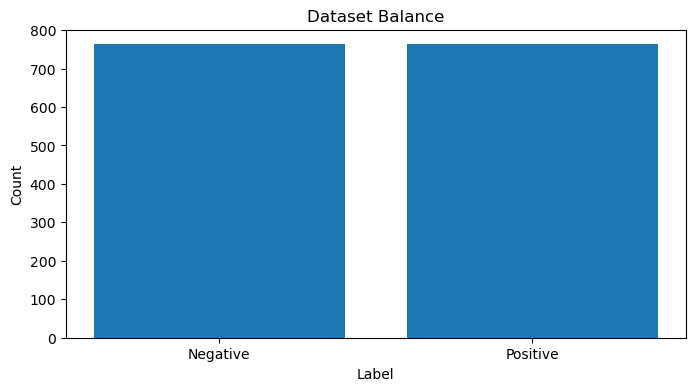

In [26]:
# Plot the balance of the dataset
plt.figure(figsize=(8, 4))
plt.bar(['Negative', 'Positive'], [len(upsampled[upsampled['label'] == 0]), len(upsampled[upsampled['label'] == 1])])
plt.title('Dataset Balance')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [ ]:
## Huggung Face Transformer 

## I want a pipleine of type sentiment analysis use the default model

In [31]:
# Hugging Face Transformer

import transformers
import torch

# Load the pre-trained sentiment analysis model
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased')

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Create a pipeline for sentiment analysis
pipeline = transformers.pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# Apply the pipeline to the text
results = pipeline(full_corpus['text'].iloc[0])
print(results)

# Apply the pipeline to the text
full_corpus['label'] = full_corpus['text'].apply(lambda x: pipeline(x)[0]['label'])

# Check the new distribution
print(full_corpus['label'].value_counts())

# Save the corpus with labels




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


[{'label': 'LABEL_0', 'score': 0.5308377146720886}]


Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (514) must match the size of tensor b (512) at non-singleton dimension 1